In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [2]:
#We now implement Simon's algorithm for the above example for  2 -qubits with a  s=11 .

In [3]:
s = '11'

In [4]:
# Creating registers
# qubits for querying the oracle and finding the hidden period s
qr = QuantumRegister(2*len(str(s)))
# classical registers for recording the measurement from qr
cr = ClassicalRegister(2*len(str(s)))

simonCircuit = QuantumCircuit(qr, cr)
barriers = True

# Apply Hadamard gates before querying the oracle
for i in range(len(str(s))):
    simonCircuit.h(qr[i])    
    
# Apply barrier 
if barriers:
    simonCircuit.barrier()

# Apply the query function
## 2-qubit oracle for s = 11
simonCircuit.cx(qr[0], qr[len(str(s)) + 0])
simonCircuit.cx(qr[0], qr[len(str(s)) + 1])
simonCircuit.cx(qr[1], qr[len(str(s)) + 0])
simonCircuit.cx(qr[1], qr[len(str(s)) + 1])  

# Apply barrier 
if barriers:
    simonCircuit.barrier()

# Measure ancilla qubits
for i in range(len(str(s)), 2*len(str(s))):
    simonCircuit.measure(qr[i], cr[i])

# Apply barrier 
if barriers:
    simonCircuit.barrier()

# Apply Hadamard gates to the input register
for i in range(len(str(s))):
    simonCircuit.h(qr[i])

# Apply barrier 
if barriers:
    simonCircuit.barrier()

# Measure input register
for i in range(len(str(s))):
    simonCircuit.measure(qr[i], cr[i])

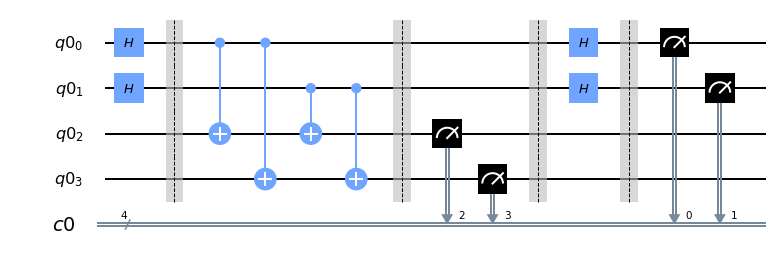

In [5]:
simonCircuit.draw(output='mpl')

{'00': 499, '11': 525}


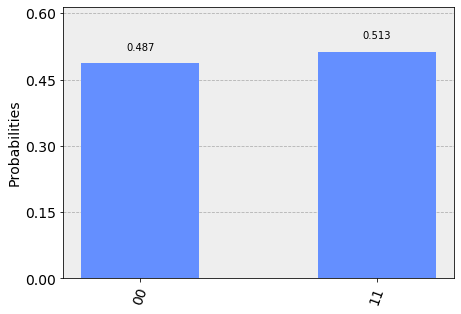

In [6]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(simonCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()

# Categorize measurements by input register values
answer_plot = {}
for measresult in answer.keys():
    measresult_input = measresult[len(str(s)):]
    if measresult_input in answer_plot:
        answer_plot[measresult_input] += answer[measresult]
    else:
        answer_plot[measresult_input] = answer[measresult] 

# Plot the categorized results
print( answer_plot )
plot_histogram(answer_plot)

In [7]:
# Calculate the dot product of the results
def sdotz(a, b):
    accum = 0
    for i in range(len(a)):
        accum += int(a[i]) * int(b[i])
    return (accum % 2)

print('s, z, s.z (mod 2)')
for z_rev in answer_plot:
    z = z_rev[::-1]
    print( '{}, {}, {}.{}={}'.format(s, z, s,z,sdotz(s,z)) )

s, z, s.z (mod 2)
11, 00, 11.00=0
11, 11, 11.11=0


In [8]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_burlington


In [9]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(simonCircuit, backend=backend, shots=shots)

job_monitor(job, interval = 2)

Job Status: job has successfully run


{'00': 499, '11': 525}


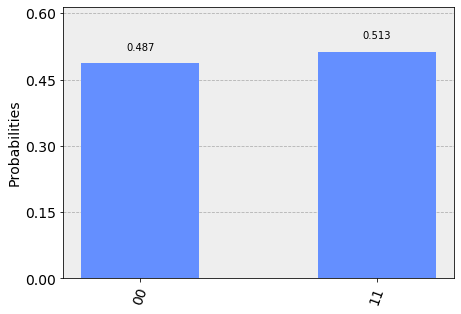

In [10]:
# Categorize measurements by input register values
answer_plot = {}
for measresult in answer.keys():
    measresult_input = measresult[len(str(s)):]
    if measresult_input in answer_plot:
        answer_plot[measresult_input] += answer[measresult]
    else:
        answer_plot[measresult_input] = answer[measresult] 

# Plot the categorized results
print( answer_plot )
plot_histogram(answer_plot)

In [11]:
# Calculate the dot product of the most significant results
print('s, z, s.z (mod 2)')
for z_rev in answer_plot:
    if answer_plot[z_rev] >= 0.1*shots:
        z = z_rev[::-1]
        print( '{}, {}, {}.{}={}'.format(s, z, s,z,sdotz(s,z)) )

s, z, s.z (mod 2)
11, 00, 11.00=0
11, 11, 11.11=0
